In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import numpy as np

In [2]:
model = nengo.Network(seed=1)
with model:
    people = nengo.Ensemble(n_neurons=500, dimensions=3,
                            neuron_type = nengo.LIFRate(),
                            seed=2,
                            radius=2)
    
    stim = nengo.Node([0.7,  # probability 
                       1.0,  # value
                       0.0,  # decision
                      ])
    
    decision = nengo.Node(None, size_in=1)
    nengo.Connection(stim, people)
    
    def decision_rule(x):
        return x[2]
    
    c_decode = nengo.Connection(people, decision, function=decision_rule)
    
    def gossip(x):
        expected_value = max(x[0],0)*x[1]
        if expected_value > 0.5:
            decide = 1.0
        else:
            decide = -1.0
        return 0, 0, decide + x[2]
    c = nengo.Connection(people, people, function=gossip, synapse=0.1,
                     solver=nengo.solvers.LstsqL2(weights=False))
    
    p_decision = nengo.Probe(decision, synapse=0.0)
    p_belief = nengo.Probe(people, synapse=0.0)
    
    

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

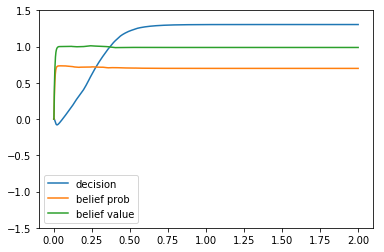

In [3]:
sim = nengo.Simulator(model)
recurrent_decoder = sim.data[c].weights
encoder = sim.data[people].encoders
output_decoder = sim.data[c_decode].weights

initial_weight_matrix = np.dot(encoder, recurrent_decoder)


with sim:
    sim.run(2.0)
plt.plot(sim.trange(), sim.data[p_decision], label='decision')
plt.plot(sim.trange(), sim.data[p_belief][:,0], label='belief prob')
plt.plot(sim.trange(), sim.data[p_belief][:,1], label='belief value')
plt.ylim(-1.5, 1.5)
plt.legend()

In [10]:
class ControlledMatrix(object):
    def __init__(self, matrix):
        self.matrix = matrix
    def update(self, t, x):
        activity = x   # big vector of everyone's activity
        prod = np.outer(x, x)
        learning_rate = 1e-20
        self.matrix += learning_rate * prod
        # add code here to adjust matrix
        return np.dot(self.matrix, x)
    def make_node(self):
        return nengo.Node(self.update, size_in=self.matrix.shape[1], size_out=self.matrix.shape[0])
    

model = nengo.Network(seed=1)
with model:
    people = nengo.Ensemble(n_neurons=500, dimensions=3,
                            #encoders= ???,
                            neuron_type = nengo.LIFRate(),
                            seed=2,
                            radius=2)
    
    stim = nengo.Node([0.7,  # probability 
                       1.0,  # value
                       0.0,  # decision
                      ])
    
    decision = nengo.Node(None, size_in=1)
    nengo.Connection(stim, people)
    
    def decision_rule(x):
        return x[2]
    
    nengo.Connection(people, decision, function=decision_rule)
    
    matrix = ControlledMatrix(initial_weight_matrix/people.radius)
    matrix_node = matrix.make_node()
    
    
    nengo.Connection(people.neurons, matrix_node, synapse=0.1)
    nengo.Connection(matrix_node, people.neurons, synapse=None)    
    
        
    p_decision = nengo.Probe(decision, synapse=0.0)
    p_belief = nengo.Probe(people, synapse=0.0)
    
sim = nengo.Simulator(model)  
with sim:
    sim.run(2.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

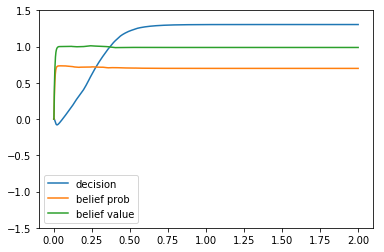

In [11]:
plt.plot(sim.trange(), sim.data[p_decision], label='decision')
plt.plot(sim.trange(), sim.data[p_belief][:,0], label='belief prob')
plt.plot(sim.trange(), sim.data[p_belief][:,1], label='belief value')
plt.ylim(-1.5, 1.5)
plt.legend()